File for all figures in the paper.

In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import multiprocess as mp
import pickle

from coin import COIN
from environments import CustomMountainCarEnv
from rl import QLearningAgent, COINQLearningAgent

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Figure 1: Contextualisation and Clustering

## Plot effect of contextual policies on a training environment

In [11]:
# Set scale factors for testing
sf = np.concatenate([
    0.0*np.ones((5000, )), 
    1.0*np.ones((5000, )),
    0.5*np.ones((5000, )),
    1.0*np.ones((5000, )),
    0.0*np.ones((5000, )),
    0.5*np.ones((5000, ))
    ])

train_basic = True # Set to True to train the models, otherwise load saved values
train_coin = True
train_oracle = True

MAX_CORES = 17
N_REPS = 1 # Number of repetitions of each model for averaging


Generate rewards for basic no-context model.

In [12]:
def run_single_rep(rep_id, sf):
    """
    Runs one repetition of training across all amplitudes in sf.
    Returns the list of rewards.
    """
    # Imports for multiprocessing
    from environments import CustomMountainCarEnv
    from rl import QLearningAgent
    # Create a fresh agent and environment inside each process

    env = CustomMountainCarEnv(amplitude=1.0, render_mode="none")
    agent = QLearningAgent(
        env=env,
        num_position_bins=30,
        num_velocity_bins=30,
        alpha=0.1,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.999,
        min_epsilon=0.01
    )

    rewards_for_this_rep = []
    for i, amplitude in enumerate(sf):
        # Create the environment for each amplitude
        env = CustomMountainCarEnv(amplitude=amplitude, render_mode="none")
        
        # Train the agent in the current context
        training_reward = agent.train_step(env=env, max_steps_per_episode=200)
        rewards_for_this_rep.append(training_reward)

        if (i + 1) % 500 == 0:
            print(f"Repetition {rep_id}, Amplitude {amplitude}: Training reward = {training_reward}")

    return rewards_for_this_rep

REWARDS_PATH = "models/fig1a_rewards_basic.npy"
if train_basic:
    # Number of repetitions and number of parallel processes:
    n_reps = N_REPS
    n_processes = MAX_CORES
        
    # Create a Pool of workers
    with mp.Pool(processes=n_processes) as pool:
        # Map each repetition to the function run_single_rep
        all_results = pool.starmap(run_single_rep, [(rep, sf) for rep in range(n_reps)])
        
    # all_results is a list of lists: one list of rewards for each repetition
    # Convert to a NumPy array, then average over axis=0 to get mean reward per amplitude
    all_results_array = np.array(all_results)  # shape: (n_reps, len(sf))
    rewards_basic = np.mean(all_results_array, axis=0)

    # Save results
    np.save(REWARDS_PATH, rewards_basic)
    print(f"Training complete. Rewards saved to '{REWARDS_PATH}'.")
else:
    # Load the saved results from the training
    if os.path.exists(REWARDS_PATH):
        rewards_basic = np.load(REWARDS_PATH)
        print(f"Loaded rewards from '{REWARDS_PATH}'.")
    else:
        raise FileNotFoundError(f"No saved rewards found at '{REWARDS_PATH}'.")

Training complete. Rewards saved to 'models/fig1a_rewards_basic.npy'.


Train COIN Model - Drift Based

In [13]:
# Initialize contextual model from COIN

# We store probability p(c|y,...) here and not p(c|...) where ... are previous values
store = [
    "responsibilities",
    "state_feedback",
]

COIN_PATH = "models/fig1a_coin_model_out.npy"

if train_coin:
    coin_model = COIN(
        prior_precision_drift=1.0,
        prior_mean_retention=0.0,
        sigma_sensory_noise = 0.003, 
        sigma_motor_noise = 0.00182, 
        store=store,
        runs=N_REPS,
        max_cores=MAX_CORES,
    ) # use default parameters for now
    
    # COIN model takes a long time to run - we simplify calculation here by assuming that 
    # the scale factor stays the same every 50 episodes.
    coin_model.perturbations = sf[::50]

    output = coin_model.simulate_coin()
    
    # Save coin model output
    with open(COIN_PATH, 'wb') as f:
        pickle.dump(output, f)
else:
    # Load the saved COIN model output
    if os.path.exists(COIN_PATH):
        with open(COIN_PATH, 'rb') as f:
            output = pickle.load(f)
        print(f"Loaded COIN model output from '{COIN_PATH}'.")
    else:
        raise FileNotFoundError(f"No saved COIN model output found at '{COIN_PATH}'.")
    

resp = np.array([output["runs"][i]["responsibilities"] for i in range(N_REPS)])
p_contexts = np.sum(resp, axis=2)
p_contexts = p_contexts / np.sum(p_contexts, axis=1, keepdims=True)

# Extend p_contexts by nearest neighbour sampling to match with episodes length
p_contexts = np.repeat(p_contexts, repeats=50, axis=-1)

Simulting the COIN model


In [18]:
# Now we train our Q-learning agent (COIN)
# Begin training loop       
def run_single_rep(rep_id, sf, p_context):
    """
    Runs one repetition of training across all amplitudes in sf.
    Returns the list of rewards.
    """
    # Imports for multiprocessing
    from environments import CustomMountainCarEnv
    from rl import COINQLearningAgent
    # Create a fresh agent and environment inside each process

    C = p_context.shape[0]

    env = CustomMountainCarEnv(amplitude=1.0, render_mode="none")
    agent = COINQLearningAgent(
        env=env,
        max_contexts=C,
        num_position_bins=30,
        num_velocity_bins=30,
        alpha=0.1,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.999
    )

    rewards_for_this_rep = []
    for i, amplitude in enumerate(sf):
        # Create the environment for each amplitude
        env = CustomMountainCarEnv(amplitude=amplitude, render_mode="none")
        
        # Train the agent in the current context
        training_reward = agent.train_step(env=env, p_context=p_context[:,i], max_steps_per_episode=200)
        rewards_for_this_rep.append(training_reward)

        if (i + 1) % 500 == 0:
            print(f"Repetition {rep_id}, Amplitude {amplitude}: Training reward = {training_reward}")

    return rewards_for_this_rep

REWARDS_PATH = "models/fig1a_rewards_coin.npy"
if train_coin:
    # Number of repetitions and number of parallel processes:
    n_reps = N_REPS
    n_processes = MAX_CORES
        
    # Create a Pool of workers
    with mp.Pool(processes=n_processes) as pool:
        # Map each repetition to the function run_single_rep
        all_results = pool.starmap(run_single_rep, [(rep, sf, p_contexts[rep,...]) for rep in range(n_reps)])
        
    # all_results is a list of lists: one list of rewards for each repetition
    # Convert to a NumPy array, then average over axis=0 to get mean reward per amplitude
    all_results_array = np.array(all_results)  # shape: (n_reps, len(sf))
    rewards_coin = np.mean(all_results_array, axis=0)

    # Save results
    np.save(REWARDS_PATH, rewards_coin)
    print(f"Training complete. Rewards saved to '{REWARDS_PATH}'.")
else:
    # Load the saved results from the training
    if os.path.exists(REWARDS_PATH):
        rewards_coin = np.load(REWARDS_PATH)
        print(f"Loaded rewards from '{REWARDS_PATH}'.")
    else:
        raise FileNotFoundError(f"No saved rewards found at '{REWARDS_PATH}'.")

Training complete. Rewards saved to 'models/fig1a_rewards_coin.npy'.


Train COIN Model - Retention Based

In [ ]:
# Initialize contextual model from COIN

# We store probability p(c|y,...) here and not p(c|...) where ... are previous values
store = [
    "responsibilities",
    "state_feedback",
]

COIN_PATH = "models/fig1a_coin_model_out.npy"

if train_coin:
    coin_model = COIN(
        sigma_sensory_noise = 0.003, 
        sigma_motor_noise = 0.00182, 
        store=store,
        runs=N_REPS,
        max_cores=MAX_CORES,
    ) # use default parameters for now
    
    # COIN model takes a long time to run - we simplify calculation here by assuming that 
    # the scale factor stays the same every 50 episodes.
    coin_model.perturbations = sf[::50]

    output = coin_model.simulate_coin()
    
    # Save coin model output
    with open(COIN_PATH, 'wb') as f:
        pickle.dump(output, f)
else:
    # Load the saved COIN model output
    if os.path.exists(COIN_PATH):
        with open(COIN_PATH, 'rb') as f:
            output = pickle.load(f)
        print(f"Loaded COIN model output from '{COIN_PATH}'.")
    else:
        raise FileNotFoundError(f"No saved COIN model output found at '{COIN_PATH}'.")
    

resp = np.array([output["runs"][i]["responsibilities"] for i in range(N_REPS)])
p_contexts = np.sum(resp, axis=2)
p_contexts = p_contexts / np.sum(p_contexts, axis=1, keepdims=True)

# Extend p_contexts by nearest neighbour sampling to match with episodes length
p_contexts = np.repeat(p_contexts, repeats=50, axis=-1)

Simulting the COIN model


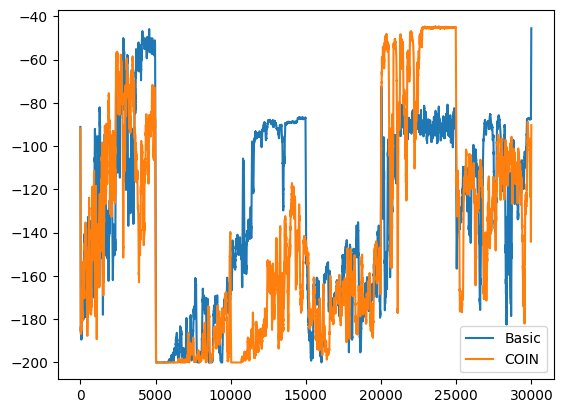

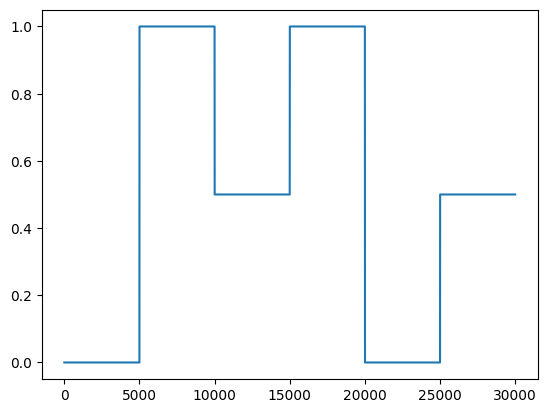

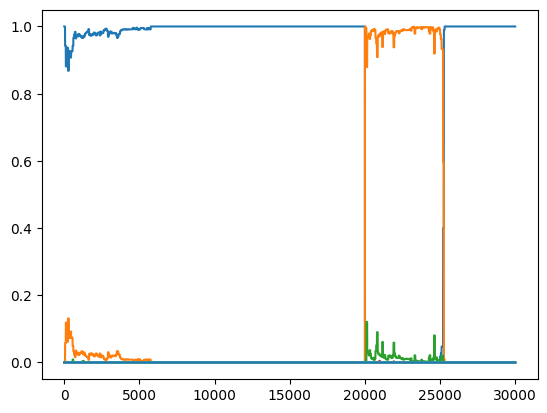

In [ ]:
# Smoothen rewards
rewards_b_smooth = np.convolve(rewards_basic, np.ones(50)/50, mode='same')
rewards_c_smooth = np.convolve(rewards_coin, np.ones(50)/50, mode='same')


plt.plot(rewards_b_smooth, label='Basic')
plt.plot(rewards_c_smooth, label='COIN')
plt.legend()
plt.show()

plt.plot(sf)
plt.show()

plt.plot(p_contexts[0,...].T)
plt.show()

Train Oracle Model

In [21]:
# Oracle model has an agent for each context
env = CustomMountainCarEnv(amplitude=1.0, render_mode="none")
agents = [QLearningAgent(
    env=env,
    num_position_bins=30,
    num_velocity_bins=30,
    alpha=0.1,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.999,
    min_epsilon=0.01
) for _ in range(C)]

true_contexts = np.concatenate([
    np.ones((500, ), dtype=int), 
    2*np.ones((500, ), dtype=int),
    3*np.ones((500, ), dtype=int),
    np.ones((500, ), dtype=int),
    2*np.ones((500, ), dtype=int),
    4*np.ones((500, ), dtype=int)
    ])

rewards_oracle = []

for i in range(0,np.size(sf)):
    # Create the MountainCar environment with the true amplitude
    env = CustomMountainCarEnv(amplitude=sf[i], render_mode="none")

    # Train the agent in the current context
    agent = agents[true_contexts[i]-1]
    training_reward = agent.train_step(
        env=env,
        max_steps_per_episode=1000
    )

    rewards_oracle.append(training_reward)

    # Print the average training reward every 500 episodes
    if ((i+1)%500 == 0):
        print(f"Episode {i+1}, Training reward: {np.mean(rewards_oracle[-500:])}")

Episode 500, Training reward: -259.846
Episode 1000, Training reward: -820.274
Episode 1500, Training reward: -952.63
Episode 2000, Training reward: -173.964
Episode 2500, Training reward: -374.906
Episode 3000, Training reward: -990.66
